In [1]:
import requests, re
import pandas as pd, numpy as np
from bs4 import BeautifulSoup

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

In [3]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options  

In [4]:
reservoir_id = 'ctl00_cpMainContent_DropDownList1'
year_id = 'ctl00_cpMainContent_Year_list'
week_id = 'ctl00_cpMainContent_weekList'
data_fetch_button = 'ctl00_cpMainContent_Button1'
table_id = 'ctl00_cpMainContent_GridView1'

In [5]:
col_name = ['Reservoir','Date','Gross_Storage(TMC)','Reservoir_level(ft/m)','Inflow','Outflow']

In [6]:
url = 'https://www.ksndmc.org/Reservoir_Details_Kn.aspx'
chromium_driver_path = '../../chromium_web_driver/chromedriver'

In [7]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  

In [8]:
# To see the browser in action, remove the options parameter
driver = webdriver.Chrome(executable_path= chromium_driver_path,options=chrome_options)
driver.get(url)

In [9]:
def extract_table_data(page):
    soup = BeautifulSoup(page,'html.parser')
    table = soup.find(id = table_id)
    df = pd.read_html(str(table))[0]
    df.iloc[:,1]=df.apply(lambda x:pd.to_datetime(x[1]).date(),axis=1)
    return df.values

In [10]:
error_array = []

In [11]:
# Fetches the data for all weeks & years available, each reservoir data may take 5 min to scrape
# Loop through Reservoir-year-week wise

def fetch_data(reservoir_list=['Harangi'],year_list=None,week_list=None,file_name_append=''):
    
    if(len(reservoir_list) == 0):
        print('Reservoir list empty')
        return -1
    
    if(year_list == None):
        year = Select(driver.find_element_by_id(year_id))
        year_list = [x.get_attribute('value') for x in year.options]
    else:
        year_list = list(map(lambda x:str(x),year_list))

    if(week_list == None):
        week = Select(driver.find_element_by_id(week_id))
        week_list = [x.get_attribute('value') for x in week.options]
    else:
        week_list = list(map(lambda x:str(x),week_list))
        
    for reservoir in reservoir_list: 
        print('Fetching data for',reservoir)
        select_reservoir = Select(driver.find_element_by_id(reservoir_id))
        select_reservoir.select_by_value(reservoir) 
        reservoir_flow_details = np.array(col_name)
        for yr_idx in year_list:  
            select_year = Select(driver.find_element_by_id(year_id))
            select_year.select_by_value(yr_idx)
            for week_idx in week_list:
                try:
                    select_week = Select(driver.find_element_by_id(week_id))
                    select_week.select_by_value(week_idx)
                    driver.find_element_by_id(data_fetch_button).click()
                    WebDriverWait(driver,3).until(EC.presence_of_element_located((By.ID,week_id)))
                    page = str(driver.page_source)
                    if('NO RECORD' in page): continue
                    else: reservoir_flow_details=np.vstack([reservoir_flow_details,extract_table_data(page)])
                except:
                    error_array.append(reservoir_flow_details[-1])
        # Save the data 
        print('Data fetch completed for',reservoir,'\n')
        np.savetxt(reservoir+file_name_append+'.csv',reservoir_flow_details,fmt='%s',delimiter=',')              

## Download Data

#####  Run all the above cells before downloading the data

In [12]:
reservoir_key = \
['Linganamakki',
'Supa',
'Varahi',
'Harangi',
'Hemavathi',
'K.R.S',
'Kabini',
'Bhadra',
'Tungabhadra',
'Ghataprabha',
'Malaprabha',
'Almatti',
'Narayanapura']

In [13]:
# Use the above reservoir keys here to get the data
req_reservoirs = ['K.R.S']

In [14]:
# To get the data for all years, all weeks remove the corresponding parameter from the function
# Only reservoir list is mandatory
fetch_data(req_reservoirs,year_list=[2019],week_list=[31],file_name_append='_31')

Fetching data for K.R.S
Data fetch completed for K.R.S 



In [15]:
if(len(error_array)==0):print(" Hurray!, No error")
else:error_array

 Hurray!, No error


### EDA K.R.S

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
import os,glob
# %matplotlib notebook

In [17]:
glob.glob('*.csv')

['Bhadra.csv',
 'Kabini.csv',
 'Alamatti.csv',
 'Varahi.csv',
 'Supa.csv',
 'Linganamakki.csv',
 'K.R.S.csv',
 'Harangi.csv',
 'Tungabhadra.csv',
 'Hemavathi.csv',
 'K.R.S_31.csv']

In [18]:
# Max storage of K.R.S in TMC
gross_storage =  49.45 

In [19]:
krs = pd.read_csv('K.R.S.csv')

In [20]:
krs.tail()

,Reservoir,Date,Gross_Storage(TMC),Reservoir_level(ft/m),Inflow,Outflow
2959,K.R.S,2019-08-01,12.92,84.50,6511.0,9972
2960,K.R.S,2019-08-02,12.61,83.90,6512.0,9933
2961,K.R.S,2019-08-03,12.39,83.45,5104.0,7589
2962,K.R.S,2019-08-04,12.27,83.20,4782.0,8332
2963,K.R.S,2019-08-05,12.22,83.10,5654.0,6149


In [21]:
krs = krs[krs['Gross_Storage(TMC)']!=0]

In [22]:
# Scale the data by the max gross storage capacity

krs['storage_level'] = krs['Gross_Storage(TMC)']*100/gross_storage 

In [23]:
# Generate the dates for the desired years
date_range = pd.date_range('2011-01-01','2019-12-31')

In [24]:
krs.set_index('Date',inplace=True)

In [25]:
krs.index = pd.DatetimeIndex(krs.index)

In [26]:
krs = krs.reindex(date_range,fill_value=np.nan)

In [27]:
krs.reset_index(inplace=True)

In [28]:
krs.rename(columns={"index":'Date'},inplace=True)

In [29]:
def plot_storage_year(year_list,title='',months=[1,12]):
    # Generate month array to mark ticks, consider a leap year for max coverage.
    num_days=pd.to_datetime('2012-'+str(months[1])+'-1').days_in_month
    dates = pd.date_range('2012-'+str(months[0])+'-01','2012-'+str(months[1])+'-'+str(num_days))
    x_ticks = [ datetime.date(1900,x.month,1).strftime('%b') if x.day==1 else '' for x in dates]
    fig,ax = plt.subplots(figsize=(10,7))
    for yr in year_list:
        num_days=pd.to_datetime(str(yr)+'-'+str(months[1])+'-1').days_in_month
        mask = (krs['Date']>=pd.datetime(yr,months[0],1)) & (krs['Date']<=pd.datetime(yr,months[1],num_days))
        data = krs[mask]['storage_level']
        data = data[data!=0] # Remove outliers
#         data = data.drop(data[data==0].index) # Remove outliers 
        ax.plot(range(1,len(data)+1),data,label=yr)

    plt.ylabel('Gross Storage level % ')
    plt.title('KRS storage levels ' +title)
    plt.xticks(range(1,len(x_ticks)+1),x_ticks)
    plt.yticks(range(0,110,10))
    ax.legend(loc='best',bbox_to_anchor=(1,.5))
    plt.show()

In [30]:
year_wise_group =  krs.groupby(krs.Date.dt.year)['storage_level']

In [31]:
# Deficit years are those where dam failed to fill up
deficit_year = year_wise_group.max() < 100
deficit_year.index[deficit_year]

Int64Index([2012, 2015, 2016, 2017, 2019], dtype='int64', name='Date')

In [32]:
# Bountiful years where dam fille up to max level
bountiful_year = year_wise_group.max() == 100
bountiful_year.index[bountiful_year]

Int64Index([2011, 2013, 2014, 2018], dtype='int64', name='Date')

### Storage levels ( % )

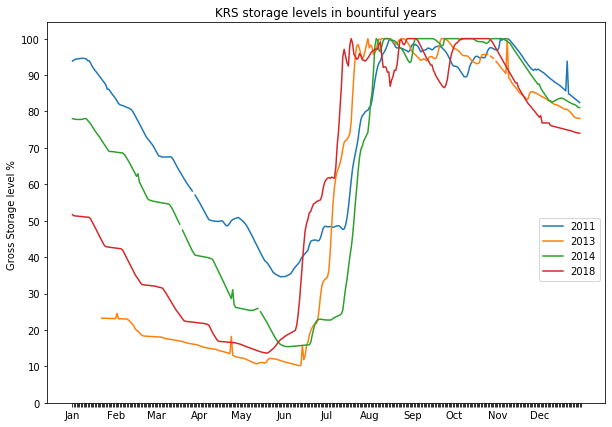

In [33]:
plot_storage_year(bountiful_year.index[bountiful_year],'in bountiful years',months=[1,12])

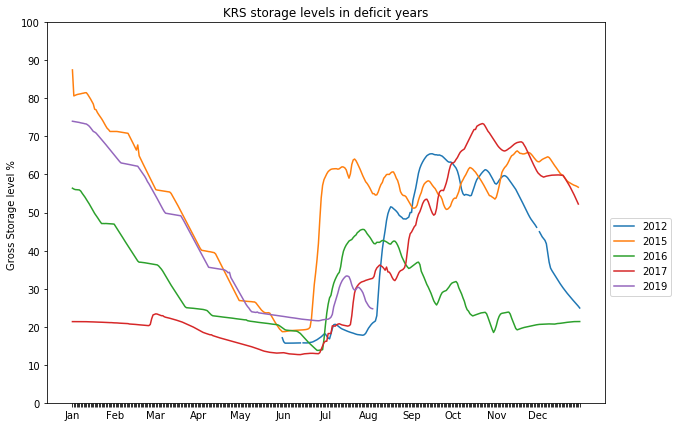

In [34]:
plot_storage_year(deficit_year.index[deficit_year],'in deficit years')

#### In the past 9 years only in 2012 was the storage level below the current year by end of July

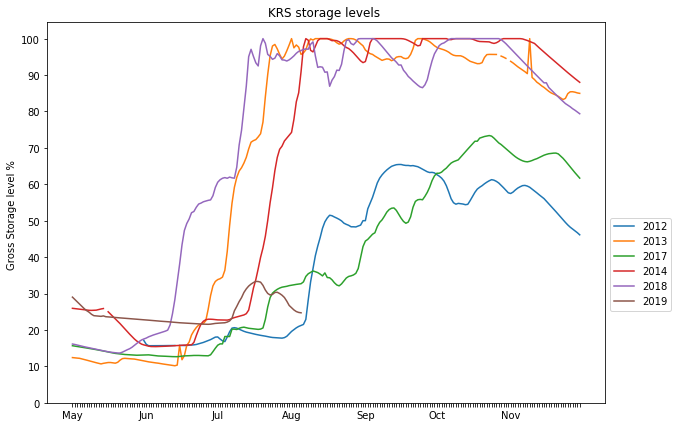

In [35]:
plot_storage_year([2012,2013,2017,2014,2018,2019],months=[5,11])

#### Stark contrast to last year storage levels in July, yawning gap

## Explore month wise 

In [36]:
def data_month(months=[1,12]):
    month_mask = (krs.Date.dt.month>=months[0])&(krs.Date.dt.month<=months[1])    
    data_group_month = krs[month_mask].groupby([krs.Date.dt.year,krs.Date.dt.month])['storage_level']
    return data_group_month

year_month_wise_max = data_month().max()
year_month_wise_min = data_month().min()

In [37]:
def table_reformat(table):
    months_of_interest = table.index.get_level_values(level=1).unique()
    month_names = pd.date_range('2016-'+str(months_of_interest[0])+'-01','2016-'+str(months_of_interest[-1])+'-07',freq='MS').strftime("%b").tolist()
    table = table.reset_index(level=0)
    table.rename(columns={'Date':'Year'},inplace=True)
    table.index.names=['Month']
    table = pd.pivot(table,columns='Year')
    table.replace(np.NaN,'',inplace=True)
    table.rename(index=dict(zip(range(months_of_interest[0],months_of_interest[-1]+1),month_names)),inplace=True)
    table.columns=table.columns.droplevel()
    return table

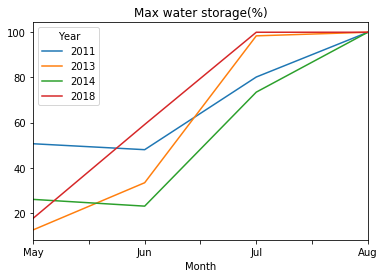

In [38]:
df = table_reformat(data_month(months=[5,8]).max())
df[bountiful_year.index[bountiful_year].values].plot(title='Max water storage(%)')

#### Min storage level(% of max) in each month year wise

In [39]:
table_reformat(data_month(months=[5,8]).max())

Year,2011,2012,2013,2014,2015,2016,2017,2018,2019
Month,,,,,,,,,
May,50.596562,17.087968,12.416582,25.945399,26.875632,21.961577,15.672396,17.532861,29.019211
Jun,47.967644,18.038423,33.326593,22.952477,57.148635,19.453994,14.984833,59.130435,22.750253
Jul,80.161780,20.626896,98.402427,73.468150,64.064712,45.581395,32.173913,100.000000,33.326593
Aug,100.000000,51.506572,100.000000,100.000000,60.667341,44.004044,42.891810,100.000000,26.127401


### Cumulative inflows & outflows ( Units: TMC - ThousandMillionCubicFeet)

#### 177 TMC is Karntaka's total obligation to TN as measured at Biligundlu.

In [40]:
def cumulative_flow(key='Inflow',months=[1,12]):
    
    # Consider a month only if atleast 28 days figures are available
    month_mask = (krs.Date.dt.month>=months[0])&(krs.Date.dt.month<=months[1])
    data_group_month = krs[month_mask]
    total_flow = data_group_month.groupby([krs.Date.dt.year,krs.Date.dt.month])[key].sum()
    month_names = pd.date_range('2016-'+str(months[0])+'-01','2016-'+str(months[-1])+'-07',freq='MS').strftime("%b").tolist()
    # Reported inflow is considered as average for the whole day
    total_flow *= 24*3600/1e9 
    
    total_flow = total_flow.reset_index(level=0)
    total_flow.rename(columns={'Date':'Year'},inplace=True)
    total_flow.index.names=['Month']
    total_flow = pd.pivot(total_flow,columns='Year',values=key)   
    total_flow.rename(index=dict(zip(range(months[0],months[1]+1),month_names)),inplace=True)
    total_flow.loc['Total']=total_flow.sum(axis=0)
    total_flow.replace(0,'',inplace=True)

    return total_flow

In [41]:
df = cumulative_flow('Inflow')
df

Year,2011,2012,2013,2014,2015,2016,2017,2018,2019
Month,,,,,,,,,
Jan,5.343408,0.425434,0.309139,2.521757,3.033936,1.444781,0.682214,0.540086,0.88033
Feb,1.708042,,1.806538,0.710208,0.799027,0.850435,1.795910,0.402538,0.458957
Mar,1.930608,,1.004141,0.432086,0.791683,0.755482,0.891734,0.436147,0.306979
Apr,3.615408,,0.881798,0.400032,0.659664,0.419990,0.823565,0.414374,0.311126
May,2.964643,0.0291168,2.088374,1.487462,1.206058,0.352512,0.832205,3.113510,0.401328
Jun,14.033002,1.86201,14.563325,6.143990,22.199184,2.766096,3.386362,23.836982,0.593309
Jul,29.833574,8.64233,68.484960,39.434170,16.083965,28.300147,15.695510,86.539450,11.089
Aug,36.571306,22.2439,52.709530,46.711123,19.750608,19.090166,24.932794,102.328790,2.46784
Sep,39.494909,21.0377,12.370320,27.892253,16.041197,14.440550,23.757754,10.553674,


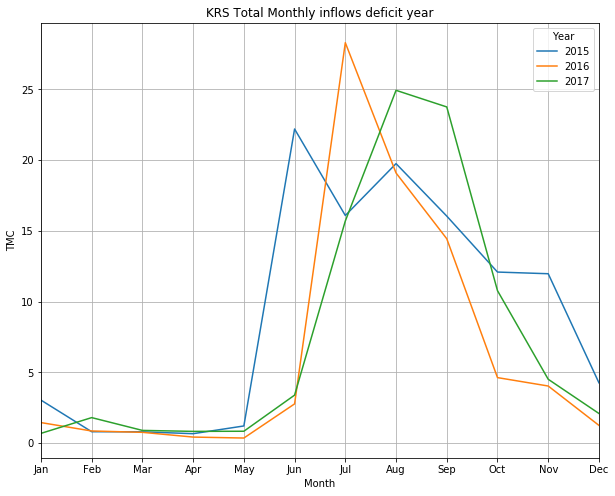

In [42]:
data = df.loc[:'Dec',deficit_year[deficit_year.index]]
ax = data.plot(title='KRS Total Monthly inflows deficit year',figsize=(10,8),xticks=range(0,12))
ax.set_ylabel('TMC')
ax.grid()


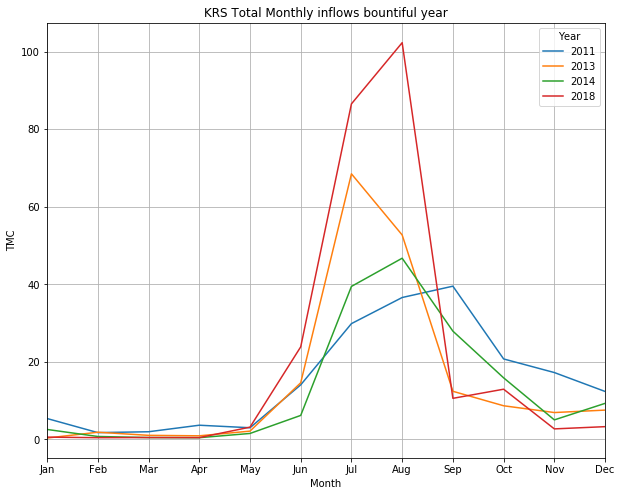

In [43]:
data = df.loc[:'Dec',bountiful_year[bountiful_year.index]]
ax = data.plot(title='KRS Total Monthly inflows bountiful year',figsize=(10,8),xticks=range(0,12))
ax.set_ylabel('TMC')
ax.grid()


In [44]:
cumulative_flow('Outflow',months=[5,8])

Year,2011,2012,2013,2014,2015,2016,2017,2018,2019
Month,,,,,,,,,
May,10.526717,0.354326,2.432678,6.135610,5.057251,1.176509,1.936138,2.255818,2.581373
Jun,7.081517,0.924307,3.634502,2.527546,2.768342,4.077734,2.306016,2.956694,0.839635
Jul,13.554864,8.051702,35.961840,8.096458,15.244848,14.313370,7.023024,68.611795,8.405510
Aug,27.908150,6.400944,52.277962,36.317376,21.864211,23.273827,19.619107,98.922211,3.626640
Total,59.071248,15.731280,94.306982,53.076989,44.934653,42.841440,30.884285,172.746518,15.453158


### Monthly cumulative inflow in deficit year

#### A measure of how much inflows  we can expect post monsoon in a lean year, such as the current one.

In [45]:
cumulative_flow()[deficit_year.index[deficit_year].values]

Year,2012,2015,2016,2017,2019
Month,,,,,
Jan,0.425434,3.033936,1.444781,0.682214,0.88033
Feb,,0.799027,0.850435,1.795910,0.458957
Mar,,0.791683,0.755482,0.891734,0.306979
Apr,,0.659664,0.419990,0.823565,0.311126
May,0.0291168,1.206058,0.352512,0.832205,0.401328
Jun,1.86201,22.199184,2.766096,3.386362,0.593309
Jul,8.64233,16.083965,28.300147,15.695510,11.089
Aug,22.2439,19.750608,19.090166,24.932794,2.46784
Sep,21.0377,16.041197,14.440550,23.757754,


### Monthly cumulative inflow in bountiful year
##### Good days, nothing to worry

In [46]:
cumulative_flow()[bountiful_year.index[bountiful_year].values]

Year,2011,2013,2014,2018
Month,,,,
Jan,5.343408,0.309139,2.521757,0.540086
Feb,1.708042,1.806538,0.710208,0.402538
Mar,1.930608,1.004141,0.432086,0.436147
Apr,3.615408,0.881798,0.400032,0.414374
May,2.964643,2.088374,1.487462,3.113510
Jun,14.033002,14.563325,6.143990,23.836982
Jul,29.833574,68.484960,39.434170,86.539450
Aug,36.571306,52.709530,46.711123,102.328790
Sep,39.494909,12.370320,27.892253,10.553674


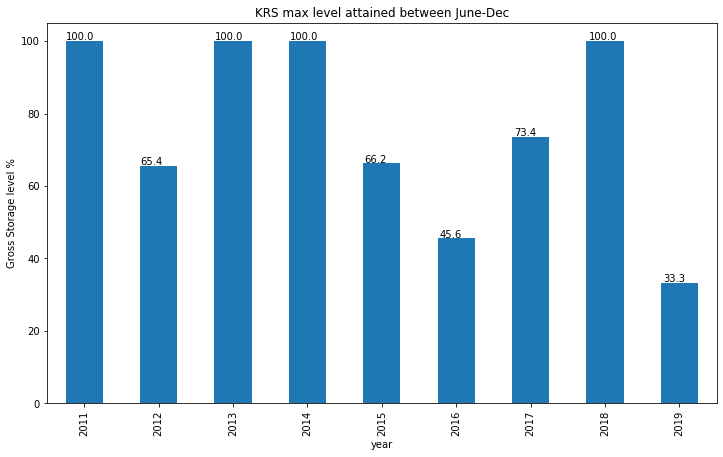

In [47]:
month_mask = krs.Date.dt.month >=6
data = krs[month_mask]
max_level_attained = data.groupby([krs.Date.dt.year])['storage_level'].max()
ax = max_level_attained.plot.bar(figsize = (12,7),title='KRS max level attained between June-Dec')
ax.set_xlabel('year')
ax.set_ylabel('Gross Storage level %')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),1)), (p.get_x() * 1.005, p.get_height() * 1.005))

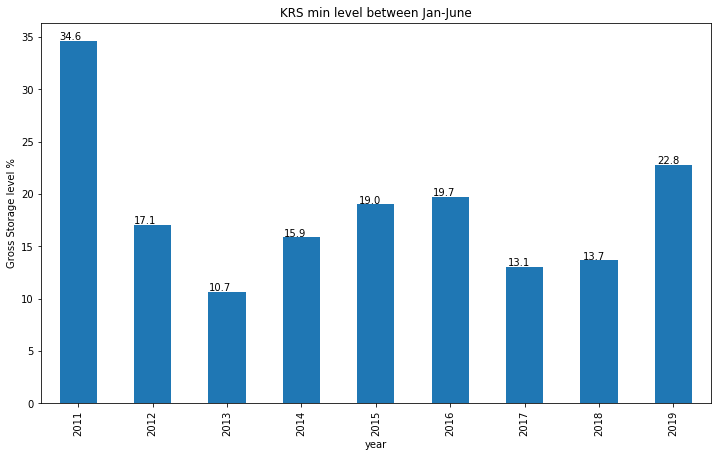

In [48]:
month_mask = krs.Date.dt.month <=5
data = krs[month_mask]

min_level_attained = data.groupby([krs.Date.dt.year])['storage_level'].min()
ax = min_level_attained.plot.bar(figsize = (12,7),title='KRS min level between Jan-June')
ax.set_xlabel('year')
ax.set_ylabel('Gross Storage level %')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),1)), (p.get_x() * 1.005, p.get_height() * 1.005))

### Min level attained

In [49]:
krs.loc[krs['Gross_Storage(TMC)'].idxmin(),:]

Date                     2013-06-13 00:00:00
Reservoir                              K.R.S
Gross_Storage(TMC)                      5.03
Reservoir_level(ft/m)                   62.8
Inflow                                   481
Outflow                                  762
storage_level                        10.1719
Name: 894, dtype: object